In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, auc
import optuna
import time

# Perform annotation

In [65]:
! perl annovar/table_annovar.pl clinvar_20250715.vcf_Annovar_Chr1 /dicos_ui_home/genomic001/sharedfs/work/IBMS-HHChenLab/2025_workshop/mingju_tsai/humandb/ -buildver hg38 -out clinvar_20250715_Chr1_gene_dbNSFP -remove -protocol refGene,dbnsfp47a_chr1 -operation g,f -nastring . -thread 2 -otherinfo

NOTICE: the --polish argument is set ON automatically (use --nopolish to change this behavior)
-----------------------------------------------------------------
NOTICE: Processing operation=g protocol=refGene

NOTICE: Running with system command <annotate_variation.pl -geneanno -buildver hg38 -dbtype refGene -outfile clinvar_20250715_Chr1_gene_dbNSFP.refGene -exonsort -nofirstcodondel clinvar_20250715.vcf_Annovar_Chr1 /dicos_ui_home/genomic001/sharedfs/work/IBMS-HHChenLab/2025_workshop/mingju_tsai/humandb/ -thread 2>
NOTICE: Output files are written to clinvar_20250715_Chr1_gene_dbNSFP.refGene.variant_function, clinvar_20250715_Chr1_gene_dbNSFP.refGene.exonic_variant_function
NOTICE: the queryfile clinvar_20250715.vcf_Annovar_Chr1 contains 325757 lines
NOTICE: threading is disabled for gene-based annotation on file with less than 1000000 input lines
NOTICE: Reading gene annotation from /dicos_ui_home/genomic001/sharedfs/work/IBMS-HHChenLab/2025_workshop/mingju_tsai/humandb/hg38_refGene

# Preprocessing clinvar file with annotation 

In [25]:
clinvar_anno = pd.read_csv("./clinvar_20250715_Chr1_gene_dbNSFP.hg38_multianno.txt",sep='\t')

In [26]:
clinvar_anno = clinvar_anno.rename(columns={
    'Otherinfo1': 'CLNREVSTAT',
    'Otherinfo2': 'CLNSIG'
})

In [27]:
clinvar_anno

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,bStatistic,bStatistic_converted_rankscore,Interpro_domain,GTEx_V8_eQTL_gene,GTEx_V8_eQTL_tissue,GTEx_V8_sQTL_gene,GTEx_V8_sQTL_tissue,eQTLGen_snp_id,CLNREVSTAT,CLNSIG
0,1,66926,66927,AG,A,intergenic,FAM138A;OR4F5,dist=30845;dist=2164,.,.,...,.,.,.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
1,1,69134,69134,A,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.A44G:p.E15G,...,994,0.00715,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Likely_benign
2,1,69308,69308,A,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.A218G:p.K73R,...,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
3,1,69314,69314,T,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.T224G:p.I75S,...,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
4,1,69404,69404,T,C,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.T314C:p.M105T,...,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325752,1,248918269,248918269,G,A,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.G932A:p.R311Q,PGBD2...",...,.,.,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
325753,1,248918277,248918277,C,T,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.C940T:p.L314F,PGBD2...",...,.,.,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
325754,1,248918322,248918322,G,A,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.G985A:p.G329S,PGBD2...",...,.,.,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
325755,1,248918358,248918358,C,T,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.C1021T:p.R341W,PGBD...",...,.,.,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance


In [28]:
clinvar_anno_missense = clinvar_anno[clinvar_anno['ExonicFunc.refGene'] == 'nonsynonymous SNV']

In [29]:
clinvar_anno_missense

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,bStatistic,bStatistic_converted_rankscore,Interpro_domain,GTEx_V8_eQTL_gene,GTEx_V8_eQTL_tissue,GTEx_V8_sQTL_gene,GTEx_V8_sQTL_tissue,eQTLGen_snp_id,CLNREVSTAT,CLNSIG
1,1,69134,69134,A,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.A44G:p.E15G,...,994,0.00715,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Likely_benign
2,1,69308,69308,A,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.A218G:p.K73R,...,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
3,1,69314,69314,T,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.T224G:p.I75S,...,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
4,1,69404,69404,T,C,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.T314C:p.M105T,...,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
5,1,69423,69423,G,A,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.G333A:p.M111I,...,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325752,1,248918269,248918269,G,A,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.G932A:p.R311Q,PGBD2...",...,.,.,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
325753,1,248918277,248918277,C,T,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.C940T:p.L314F,PGBD2...",...,.,.,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
325754,1,248918322,248918322,G,A,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.G985A:p.G329S,PGBD2...",...,.,.,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
325755,1,248918358,248918358,C,T,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.C1021T:p.R341W,PGBD...",...,.,.,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance


In [30]:
clinvar_anno_missense_clnrevstat_chr1 = clinvar_anno_missense['CLNREVSTAT'].value_counts()

In [31]:
clinvar_anno_missense_clnrevstat_chr1

CLNREVSTAT
criteria_provided,_single_submitter                     152802
criteria_provided,_multiple_submitters,_no_conflicts     24973
criteria_provided,_conflicting_classifications            6691
no_assertion_criteria_provided                            3140
reviewed_by_expert_panel                                   427
no_classification_provided                                 269
no_classification_for_the_single_variant                    32
no_classifications_from_unflagged_records                    6
Name: count, dtype: int64

In [32]:
clinvar_missense_chr1_noconflict = clinvar_anno_missense[(clinvar_anno_missense['CLNREVSTAT'] == 'reviewed_by_expert_panel')|
                           (clinvar_anno_missense['CLNREVSTAT'] == 'practice_guideline')|
                           (clinvar_anno_missense['CLNREVSTAT'] == 'criteria_provided,_single_submitter')|
                           (clinvar_anno_missense['CLNREVSTAT'] == 'criteria_provided,_multiple_submitters,_no_conflicts')]

In [33]:
clinvar_missense_chr1_noconflict

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,bStatistic,bStatistic_converted_rankscore,Interpro_domain,GTEx_V8_eQTL_gene,GTEx_V8_eQTL_tissue,GTEx_V8_sQTL_gene,GTEx_V8_sQTL_tissue,eQTLGen_snp_id,CLNREVSTAT,CLNSIG
1,1,69134,69134,A,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.A44G:p.E15G,...,994,0.00715,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Likely_benign
2,1,69308,69308,A,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.A218G:p.K73R,...,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
3,1,69314,69314,T,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.T224G:p.I75S,...,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
4,1,69404,69404,T,C,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.T314C:p.M105T,...,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
5,1,69423,69423,G,A,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.G333A:p.M111I,...,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325752,1,248918269,248918269,G,A,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.G932A:p.R311Q,PGBD2...",...,.,.,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
325753,1,248918277,248918277,C,T,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.C940T:p.L314F,PGBD2...",...,.,.,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
325754,1,248918322,248918322,G,A,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.G985A:p.G329S,PGBD2...",...,.,.,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
325755,1,248918358,248918358,C,T,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.C1021T:p.R341W,PGBD...",...,.,.,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance


In [34]:
clinvar_missense_chr1_noconflict_6classees = clinvar_missense_chr1_noconflict[clinvar_missense_chr1_noconflict['CLNSIG'].isin(["Likely_benign","Benign","Likely_pathogenic","Pathogenic","Uncertain_significance"])]


In [35]:
clinvar_missense_chr1_noconflict_6classees

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,bStatistic,bStatistic_converted_rankscore,Interpro_domain,GTEx_V8_eQTL_gene,GTEx_V8_eQTL_tissue,GTEx_V8_sQTL_gene,GTEx_V8_sQTL_tissue,eQTLGen_snp_id,CLNREVSTAT,CLNSIG
1,1,69134,69134,A,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.A44G:p.E15G,...,994,0.00715,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Likely_benign
2,1,69308,69308,A,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.A218G:p.K73R,...,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
3,1,69314,69314,T,G,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.T224G:p.I75S,...,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
4,1,69404,69404,T,C,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.T314C:p.M105T,...,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
5,1,69423,69423,G,A,exonic,OR4F5,.,nonsynonymous SNV,OR4F5:NM_001005484:exon1:c.G333A:p.M111I,...,994,0.00715,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325752,1,248918269,248918269,G,A,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.G932A:p.R311Q,PGBD2...",...,.,.,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
325753,1,248918277,248918277,C,T,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.C940T:p.L314F,PGBD2...",...,.,.,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
325754,1,248918322,248918322,G,A,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.G985A:p.G329S,PGBD2...",...,.,.,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance
325755,1,248918358,248918358,C,T,exonic,PGBD2,.,nonsynonymous SNV,"PGBD2:NM_001017434:exon3:c.C1021T:p.R341W,PGBD...",...,.,.,.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Uncertain_significance


In [36]:
plt.rcParams['font.family'] = 'DejaVu Sans'

/tmp/ipykernel_768/3920625980.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


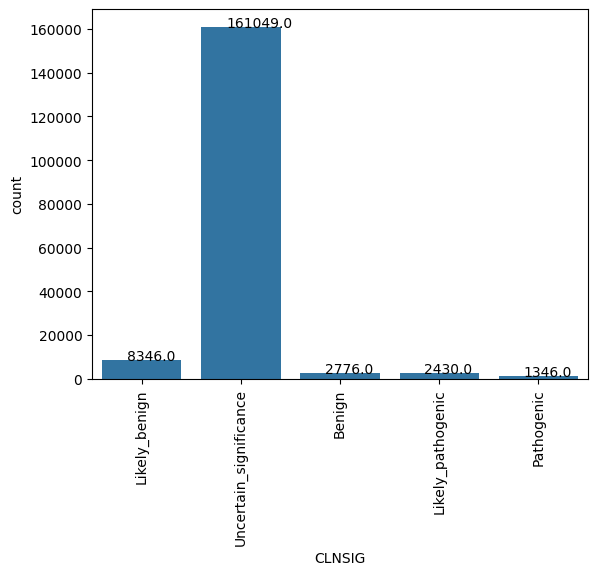

In [37]:
plt.clf()
ax = sns.countplot(x='CLNSIG', data=clinvar_missense_chr1_noconflict_6classees)

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
plt.show()

In [18]:
clinvar_chr1_missense_b_p  = clinvar_missense_chr1_noconflict_6classees[clinvar_missense_chr1_noconflict_6classees['CLNSIG'].isin(['Benign','Pathogenic'])]

In [19]:
clinvar_chr1_missense_b_p

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,bStatistic,bStatistic_converted_rankscore,Interpro_domain,GTEx_V8_eQTL_gene,GTEx_V8_eQTL_tissue,GTEx_V8_sQTL_gene,GTEx_V8_sQTL_tissue,eQTLGen_snp_id,CLNREVSTAT,CLNSIG
38,1,930165,930165,G,A,exonic,SAMD11,.,nonsynonymous SNV,"SAMD11:NM_001385640:exon3:c.G620A:p.R207Q,SAMD...",...,940,0.13648,.;.;.;.;.;.;.;.;.;.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Benign
50,1,930204,930204,G,A,exonic,SAMD11,.,nonsynonymous SNV,"SAMD11:NM_001385640:exon3:c.G659A:p.R220Q,SAMD...",...,940,0.13648,.;.;.;.;.;.;.;.;.;.;.,.,.,.,.,.,"criteria_provided,_multiple_submitters,_no_con...",Benign
84,1,930285,930285,G,A,exonic,SAMD11,.,nonsynonymous SNV,"SAMD11:NM_001385640:exon3:c.G740A:p.R247Q,SAMD...",...,940,0.13648,.;.;.;.;.;.;.;.;.;.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Benign
89,1,930314,930314,C,T,exonic,SAMD11,.,nonsynonymous SNV,"SAMD11:NM_001385640:exon3:c.C769T:p.H257Y,SAMD...",...,940,0.13648,.;.;.;.;.;.;.;.;.;.;.,.,.,.,.,.,"criteria_provided,_multiple_submitters,_no_con...",Benign
306,1,939429,939429,G,C,exonic,SAMD11,.,nonsynonymous SNV,SAMD11:NM_152486:exon7:c.G675C:p.W225C,...,940,0.13648,.;.;.,.,.,.,.,.,"criteria_provided,_single_submitter",Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324745,1,248180689,248180689,G,A,exonic,OR2M2,.,nonsynonymous SNV,OR2M2:NM_001004688:exon1:c.G704A:p.C235Y,...,976,0.04745,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",LYPD8,Colon_Transverse,.,.,.,"criteria_provided,_multiple_submitters,_no_con...",Benign
324863,1,248273336,248273336,A,G,exonic,OR2T33,.,nonsynonymous SNV,OR2T33:NM_001004695:exon1:c.T479C:p.V160A,...,982,0.03397,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_multiple_submitters,_no_con...",Benign
325141,1,248453107,248453107,C,T,exonic,OR2T2,.,nonsynonymous SNV,OR2T2:NM_001004136:exon1:c.C310T:p.L104F,...,982,0.03397,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_multiple_submitters,_no_con...",Benign
325142,1,248453117,248453117,C,A,exonic,OR2T2,.,nonsynonymous SNV,OR2T2:NM_001004136:exon1:c.C320A:p.T107N,...,982,0.03397,"GPCR, rhodopsin-like, 7TM;GPCR, rhodopsin-like...",.,.,.,.,.,"criteria_provided,_multiple_submitters,_no_con...",Benign


/tmp/ipykernel_768/681715528.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


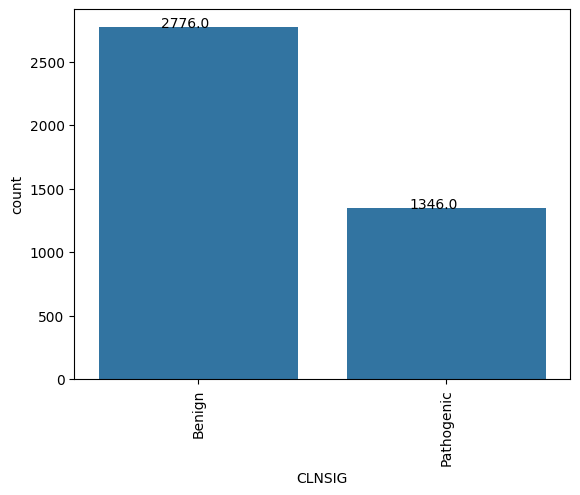

In [21]:
plt.clf()
ax = sns.countplot(x='CLNSIG', data=clinvar_chr1_missense_b_p)

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
plt.show()

In [23]:
TP = len(clinvar_chr1_missense_b_p[(clinvar_chr1_missense_b_p['MetaSVM_pred'] == 'D') & (clinvar_chr1_missense_b_p['CLNSIG'] == 'Pathogenic')])
TN = len(clinvar_chr1_missense_b_p[(clinvar_chr1_missense_b_p['MetaSVM_pred'] == 'T') & (clinvar_chr1_missense_b_p['CLNSIG'] == 'Benign')])
FP = len(clinvar_chr1_missense_b_p[(clinvar_chr1_missense_b_p['MetaSVM_pred'] == 'D') & (clinvar_chr1_missense_b_p['CLNSIG'] == 'Benign')])
FN = len(clinvar_chr1_missense_b_p[(clinvar_chr1_missense_b_p['MetaSVM_pred'] == 'T') & (clinvar_chr1_missense_b_p['CLNSIG'] == 'Pathogenic')])

# Calculate the metrics
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
ppv = TP / (TP + FP) if (TP + FP) > 0 else 0

# Display the results
metrics = {
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'Accuracy': accuracy,
    'PPV': ppv
}

metrics

{'Sensitivity': 0.8490990990990991,
 'Specificity': 0.9152356594811838,
 'Accuracy': 0.8935856475792578,
 'PPV': 0.8297872340425532}

# Extract MetaSVM_score, MetaLR_score, CADD_raw, VEST4_score, REVEL_score from annotation

In [39]:
clinvar_chr1_missense_b_p_5methods = clinvar_chr1_missense_b_p[['MetaSVM_score','MetaLR_score','CADD_raw','VEST4_score','REVEL_score','CLNSIG']]

In [40]:
clinvar_chr1_missense_b_p_5methods

,MetaSVM_score,MetaLR_score,CADD_raw,VEST4_score,REVEL_score,CLNSIG
38,-0.6569,0.171,5.525143,0.612,0.257,Benign
50,-0.7940,0.058,2.912965,0.26,0.208,Benign
84,-1.0382,0.061,0.279046,0.17,0.022,Benign
89,-1.0840,0.001,2.850487,0.329,0.103,Benign
306,-1.0338,0.023,0.126376,0.337,0.088,Benign
...,...,...,...,...,...,...
324745,-1.0548,0.000,-0.364075,0.041,0.050,Benign
324863,-1.0285,0.000,-0.281976,0.056,0.017,Benign
325141,-1.0175,0.001,1.322232,0.059,0.014,Benign
325142,-0.9628,0.001,3.092159,0.158,0.084,Benign


In [41]:
# Replace '.' with NaN
clinvar_chr1_missense_b_p_5methods.replace('.', np.nan, inplace=True)

/tmp/ipykernel_768/3087978464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinvar_chr1_missense_b_p_5methods.replace('.', np.nan, inplace=True)


In [42]:
clinvar_chr1_missense_b_p_5methods_cleaned = clinvar_chr1_missense_b_p_5methods.dropna()

In [43]:
clinvar_chr1_missense_b_p_5methods_cleaned

,MetaSVM_score,MetaLR_score,CADD_raw,VEST4_score,REVEL_score,CLNSIG
38,-0.6569,0.171,5.525143,0.612,0.257,Benign
50,-0.7940,0.058,2.912965,0.26,0.208,Benign
84,-1.0382,0.061,0.279046,0.17,0.022,Benign
89,-1.0840,0.001,2.850487,0.329,0.103,Benign
306,-1.0338,0.023,0.126376,0.337,0.088,Benign
...,...,...,...,...,...,...
324744,-1.0200,0.000,-0.423414,0.009,0.020,Benign
324745,-1.0548,0.000,-0.364075,0.041,0.050,Benign
324863,-1.0285,0.000,-0.281976,0.056,0.017,Benign
325141,-1.0175,0.001,1.322232,0.059,0.014,Benign


# splite data for machine learning

In [44]:
X = clinvar_chr1_missense_b_p_5methods_cleaned.drop(columns=['CLNSIG'])
y = clinvar_chr1_missense_b_p_5methods_cleaned['CLNSIG']

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [45]:
# Display the ratio of classes in the original, training, and test sets
print("Original class distribution:")
print(y.value_counts(normalize=True))

print("\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

Original class distribution:
CLNSIG
Benign        0.670144
Pathogenic    0.329856
Name: proportion, dtype: float64

Training set class distribution:
CLNSIG
Benign        0.670186
Pathogenic    0.329814
Name: proportion, dtype: float64

Test set class distribution:
CLNSIG
Benign        0.669975
Pathogenic    0.330025
Name: proportion, dtype: float64


In [46]:
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    
    # Initialize the Random Forest model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model using cross-validation
    accuracy = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy').mean()
    
    return accuracy

In [47]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Display the best hyperparameters
print(f'Best hyperparameters: {study.best_params}')

[I 2025-07-17 15:33:51,257] A new study created in memory with name: no-name-cc9b1fa3-bddb-4ad1-9c43-24a5c85fec98
[I 2025-07-17 15:34:50,726] Trial 0 finished with value: 0.9381987577639752 and parameters: {'n_estimators': 623, 'max_depth': 33, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9381987577639752.
[I 2025-07-17 15:35:53,677] Trial 1 finished with value: 0.9385093167701862 and parameters: {'n_estimators': 732, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9385093167701862.
[I 2025-07-17 15:36:10,524] Trial 2 finished with value: 0.9388198757763974 and parameters: {'n_estimators': 229, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9388198757763974.
[I 2025-07-17 15:37:01,307] Trial 3 finished with value: 0.9375776397515528 and parameters: {'n_estimators': 657, 'max_depth': 12,

Best hyperparameters: {'n_estimators': 545, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt'}


# Retrieve the best hyperparameters to train the final model

In [48]:
best_params = study.best_params

# Initialize the Random Forest model with the best hyperparameters
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)

# Train the model on the entire training set
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=23, min_samples_leaf=6, min_samples_split=5,
                       n_estimators=545, random_state=42)

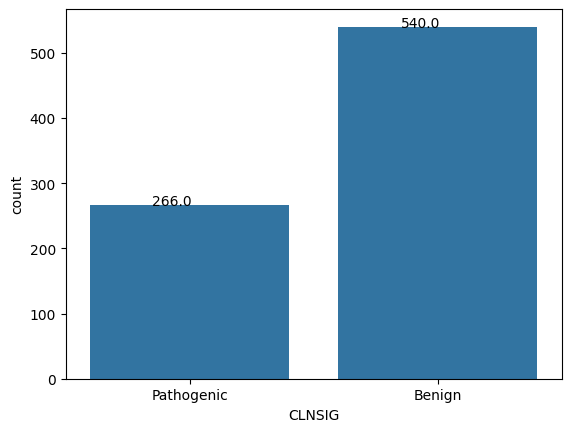

In [49]:
plt.clf()
ax = sns.countplot(x='CLNSIG', data=pd.DataFrame(y_test))

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    
plt.show()

In [50]:
pd.DataFrame(y_test)

,CLNSIG
110006,Pathogenic
226418,Benign
191626,Benign
160191,Benign
75903,Benign
...,...
91293,Pathogenic
91530,Pathogenic
323277,Pathogenic
81890,Benign


In [51]:
#Evaluate the Model
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.9466501240694789
Confusion Matrix:
[[526  14]
 [ 29 237]]
Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      0.97      0.96       540
  Pathogenic       0.94      0.89      0.92       266

    accuracy                           0.95       806
   macro avg       0.95      0.93      0.94       806
weighted avg       0.95      0.95      0.95       806



In [52]:
TP = 237
TN = 526
FP = 14
FN = 29
# Calculate the metrics
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
ppv = TP / (TP + FP) if (TP + FP) > 0 else 0

# Calculate F1-score
f1_score = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0

# Display the results
metrics = {
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'Accuracy': accuracy,
    'PPV': ppv,
    'F1-score': f1_score
}

metrics

{'Sensitivity': 0.8909774436090225,
 'Specificity': 0.9740740740740741,
 'Accuracy': 0.9466501240694789,
 'PPV': 0.9442231075697212,
 'F1-score': 0.9168278529980658}

In [53]:
# Make probability predictions on the test set
y_prob = best_model.predict_proba(X_test)[:, 1]  # Assuming binary classification and extracting the probability for class 1

In [54]:
# Calculate AUROC
auroc = roc_auc_score(y_test, y_prob)
print(f'AUROC: {auroc}')

AUROC: 0.9819305207463103


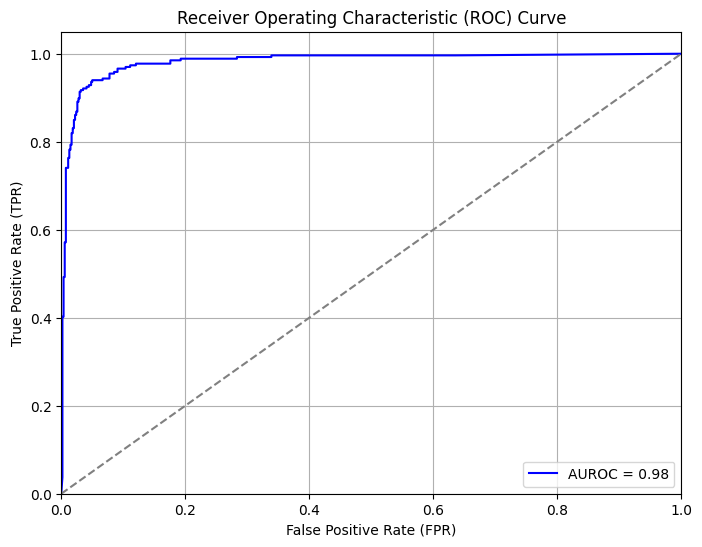

In [55]:
# Convert categorical labels to binary (0 and 1)
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Feature importance analysis

In [56]:
feature_names = X_test.columns.tolist()
start_time = time.time()
result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 10.830 seconds


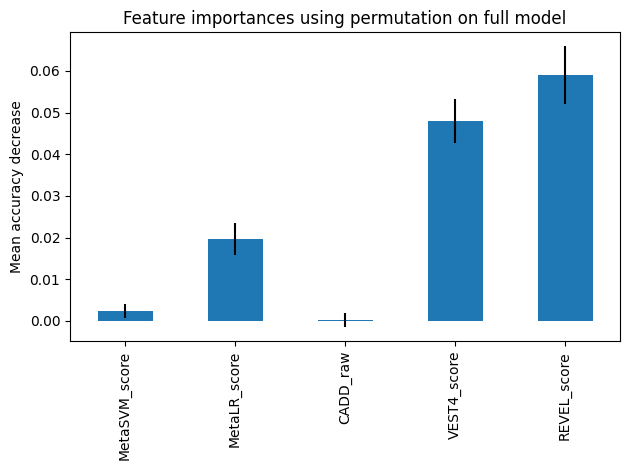

In [57]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Using Pycaret to perform ML analyses

In [58]:
clinvar_chr1_missense_b_p_5methods

,MetaSVM_score,MetaLR_score,CADD_raw,VEST4_score,REVEL_score,CLNSIG
38,-0.6569,0.171,5.525143,0.612,0.257,Benign
50,-0.7940,0.058,2.912965,0.26,0.208,Benign
84,-1.0382,0.061,0.279046,0.17,0.022,Benign
89,-1.0840,0.001,2.850487,0.329,0.103,Benign
306,-1.0338,0.023,0.126376,0.337,0.088,Benign
...,...,...,...,...,...,...
324745,-1.0548,0.000,-0.364075,0.041,0.050,Benign
324863,-1.0285,0.000,-0.281976,0.056,0.017,Benign
325141,-1.0175,0.001,1.322232,0.059,0.014,Benign
325142,-0.9628,0.001,3.092159,0.158,0.084,Benign


In [60]:
from pycaret.classification import *

In [61]:
s = setup(data = clinvar_chr1_missense_b_p_5methods,
          train_size = 0.8,
          target = 'CLNSIG',
          imputation_type = 'simple',
          session_id = 123,
          normalize = True)

,Description,Value
0,Session id,123
1,Target,CLNSIG
2,Target type,Binary
3,Target mapping,"Benign: 0, Pathogenic: 1"
4,Original data shape,"(4122, 6)"
5,Transformed data shape,"(4122, 6)"
6,Transformed train set shape,"(3297, 6)"
7,Transformed test set shape,"(825, 6)"
8,Categorical features,5
9,Rows with missing values,2.3%


In [62]:
# check model library
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [63]:
catboost = create_model('catboost')
xgboost = create_model('xgboost')
rf = create_model('rf')
svm = create_model('rbfsvm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8939,0.9620,0.8939,0.8962,0.8906,0.7465,0.7553
1,0.9121,0.9584,0.9121,0.9115,0.9116,0.7980,0.7985
2,0.9000,0.9700,0.9000,0.9002,0.8979,0.7645,0.7689
3,0.8970,0.9638,0.8970,0.8982,0.8974,0.7682,0.7685
4,0.8727,0.9575,0.8727,0.8747,0.8680,0.6935,0.7044
5,0.7939,0.9593,0.7939,0.8357,0.7619,0.4449,0.5281
6,0.9000,0.9685,0.9000,0.8997,0.8982,0.7657,0.7689
7,0.8176,0.9730,0.8176,0.8512,0.7943,0.5166,0.5843
8,0.9027,0.9642,0.9027,0.9020,0.9014,0.7729,0.7749


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6697,0.9421,0.6697,0.4519,0.5396,-0.0060,-0.0385
1,0.6697,0.9447,0.6697,0.4519,0.5396,-0.0060,-0.0385
2,0.6727,0.9540,0.6727,0.4526,0.5411,0.0000,0.0000
3,0.6727,0.9129,0.6727,0.4526,0.5411,0.0000,0.0000
4,0.6727,0.9460,0.6727,0.4526,0.5411,0.0000,0.0000
5,0.6727,0.9579,0.6727,0.4526,0.5411,0.0000,0.0000
6,0.6727,0.9612,0.6727,0.4526,0.5411,0.0000,0.0000
7,0.6748,0.9644,0.6748,0.4553,0.5437,0.0000,0.0000
8,0.6748,0.9361,0.6748,0.4553,0.5437,0.0000,0.0000


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6727,0.9159,0.6727,0.4526,0.5411,0.0000,0.0000
1,0.6727,0.9207,0.6727,0.4526,0.5411,0.0000,0.0000
2,0.6727,0.8976,0.6727,0.4526,0.5411,0.0000,0.0000
3,0.6727,0.8005,0.6727,0.4526,0.5411,0.0000,0.0000
4,0.6727,0.8971,0.6727,0.4526,0.5411,0.0000,0.0000
5,0.6727,0.9333,0.6727,0.4526,0.5411,0.0000,0.0000
6,0.6727,0.9361,0.6727,0.4526,0.5411,0.0000,0.0000
7,0.6748,0.9673,0.6748,0.4553,0.5437,0.0000,0.0000
8,0.6748,0.8713,0.6748,0.4553,0.5437,0.0000,0.0000


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7091,0.9548,0.7091,0.7969,0.6186,0.1440,0.2785
1,0.7212,0.9521,0.7212,0.8029,0.6417,0.1896,0.3236
2,0.7000,0.9571,0.7000,0.7925,0.6004,0.1090,0.2401
3,0.7485,0.9439,0.7485,0.7964,0.6950,0.2967,0.3994
4,0.7061,0.9557,0.7061,0.7954,0.6126,0.1324,0.2662
5,0.7091,0.9499,0.7091,0.7969,0.6186,0.1440,0.2785
6,0.7000,0.9725,0.7000,0.7925,0.6004,0.1090,0.2401
7,0.7325,0.9687,0.7325,0.8085,0.6612,0.2256,0.3566
8,0.7264,0.9569,0.7264,0.8054,0.6502,0.2031,0.3362


In [64]:
evaluate_model(xgboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…